# 10. Grid Index Map

## 패키지 로딩

In [1]:
import pandas as pd

In [2]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import fiona #공간데이터를 딕셔너리 형태 등으로 접근할 수 있는 라이브러리 
from fiona.crs import from_epsg # 좌표변환 

import pyproj  # 좌표변환
from pyproj import Proj, transform

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid') #whitegrid, dark, white, ticks
mpl.rc('font', family='NanumGothic') #한글 폰트 적용시
plt.rcParams["figure.figsize"] = (16,4.5) #차트 사이즈

## 공간데이터 
점 즉, 좌표나 주소로 수집되는 데이터가 필요. 특히, 원데이터가 GPS 등을 통해 좌표로 수집되는 데이터가 적합함   
이번에는 통신 중계기 CELL 분석을 통해 생성되는 유동인구 데이터를 다뤄봄  

### SKT 유동인구 - 이 데이터를 적용
좌표계는 EPSG 5179    
https://www.bigdatahub.co.kr/product/view.do?pid=1001281  

### 참조 - 서울 생활인구 
위/아래 데이터는 샘플로 실제 데이터는 유료 구매해야 함. 생활인구 데이터는 일별 데이터를 공개하고 있음   
다만, 50m 간격 좌표가 아닌 집계구/ 행정동/ 자치구 단위 데이터임  
https://data.seoul.go.kr/dataVisual/seoul/seoulLivingPopulation.do

In [1]:
df = pd.read_csv('./data/pop/2016년+3월+SKT이동통신을+이용한+성별연령별+유동인구(종로구)_2.csv', index_col=None, header=0, 
                          names=['STD_YM', 'SI_DO_NM', 'SGNG_NM', 'ADONG_NM', 'BLOCK_CD', 'X_COORD', 'Y_COORD', 'MAN_FLOW_POP_CNT_10G', 'MAN_FLOW_POP_CNT_20G', 'MAN_FLOW_POP_CNT_30G', 'MAN_FLOW_POP_CNT_40G', 'MAN_FLOW_POP_CNT_50G', 'MAN_FLOW_POP_CNT_60GU', 'WMAN_FLOW_POP_CNT_10G', 'WMAN_FLOW_POP_CNT_20G', 'WMAN_FLOW_POP_CNT_30G', 'WMAN_FLOW_POP_CNT_40G', 'WMAN_FLOW_POP_CNT_50G', 'WMAN_FLOW_POP_CNT_60GU', 'DATA_LOAD_DT'], 
                          usecols=['SI_DO_NM', 'SGNG_NM', 'ADONG_NM', 'BLOCK_CD', 'X_COORD', 'Y_COORD', 'MAN_FLOW_POP_CNT_10G', 'MAN_FLOW_POP_CNT_20G', 'MAN_FLOW_POP_CNT_30G', 'MAN_FLOW_POP_CNT_40G', 'MAN_FLOW_POP_CNT_50G', 'MAN_FLOW_POP_CNT_60GU', 'WMAN_FLOW_POP_CNT_10G', 'WMAN_FLOW_POP_CNT_20G', 'WMAN_FLOW_POP_CNT_30G', 'WMAN_FLOW_POP_CNT_40G', 'WMAN_FLOW_POP_CNT_50G', 'WMAN_FLOW_POP_CNT_60GU'],
                          dtype={'BLOCK_CD':object, 'Y_COORD':float}, #지정안하고 로딩시 나머지 항목은 잘 인식해서...2개만 지정함
                 encoding="utf-8", 
                 delimiter=',' , #항목 구분자 '\t'
                 thousands = ',' ) #천단위 쉼표 제거   
df.info() #행 수 및 컬럼 정보 df.shape()을 이용해도 됨
df.head() 

NameError: name 'pd' is not defined

In [5]:
# 레코드별 총인구, 남자 인구, 여자 인구 
# 노트패드에서 CSV 헤더의 TAB 공간을 "" + df."로 일괄 바꾸기 함 
df['POP_ALL'] = df.MAN_FLOW_POP_CNT_10G + df.MAN_FLOW_POP_CNT_20G + df.MAN_FLOW_POP_CNT_30G + df.MAN_FLOW_POP_CNT_40G + df.MAN_FLOW_POP_CNT_50G + df.MAN_FLOW_POP_CNT_60GU + df.WMAN_FLOW_POP_CNT_10G + df.WMAN_FLOW_POP_CNT_20G + df.WMAN_FLOW_POP_CNT_30G + df.WMAN_FLOW_POP_CNT_40G + df.WMAN_FLOW_POP_CNT_50G + df.WMAN_FLOW_POP_CNT_60GU
#df['POP_MAN_ALL'] = df.MAN_FLOW_POP_CNT_10G + df.MAN_FLOW_POP_CNT_20G + df.MAN_FLOW_POP_CNT_30G + df.MAN_FLOW_POP_CNT_40G + df.MAN_FLOW_POP_CNT_50G + df.MAN_FLOW_POP_CNT_60GU
#df['POP_WOMAN_ALL'] = df.WMAN_FLOW_POP_CNT_10G + df.WMAN_FLOW_POP_CNT_20G + df.WMAN_FLOW_POP_CNT_30G + df.WMAN_FLOW_POP_CNT_40G + df.WMAN_FLOW_POP_CNT_50G + df.WMAN_FLOW_POP_CNT_60GU

In [6]:
#불필요한 항목 제거
df.drop(['SI_DO_NM', 'SGNG_NM', 'ADONG_NM', 'BLOCK_CD', 'MAN_FLOW_POP_CNT_10G', 'MAN_FLOW_POP_CNT_20G', 'MAN_FLOW_POP_CNT_30G', 'MAN_FLOW_POP_CNT_40G', 'MAN_FLOW_POP_CNT_50G', 'MAN_FLOW_POP_CNT_60GU', 'WMAN_FLOW_POP_CNT_10G', 'WMAN_FLOW_POP_CNT_20G', 'WMAN_FLOW_POP_CNT_30G', 'WMAN_FLOW_POP_CNT_40G', 'WMAN_FLOW_POP_CNT_50G', 'WMAN_FLOW_POP_CNT_60GU'], axis=1, inplace=True)

In [7]:
#이상치 제거
import numpy as np
from scipy.stats import zscore
df['pop_zscore'] = zscore(df['POP_ALL'])
threshold = 3 #2는 약 95%, 3을 적용하면 약 99.73%
df['outliers'] = np.where((df['pop_zscore'] - threshold > 0), True, np.where(df['pop_zscore'] + threshold < 0, True, False))
df.drop(df[df['outliers'] == True].index,inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5596 entries, 0 to 5666
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X_COORD     5596 non-null   float64
 1   Y_COORD     5596 non-null   float64
 2   POP_ALL     5596 non-null   float64
 3   pop_zscore  5596 non-null   float64
 4   outliers    5596 non-null   bool   
dtypes: bool(1), float64(4)
memory usage: 224.1 KB


X_COORD    Y_COORD  POP_ALL  pop_zscore  outliers
0  952559.000  1956707.0    87.89   -0.373183     False
1  952608.375  1956758.0    97.53   -0.354854     False
2  952609.625  1956963.0    20.98   -0.500400     False
3  952757.500  1957117.0    65.61   -0.415544     False
4  954573.375  1957415.0    32.37   -0.478744     False

In [8]:
# 좌표 속성을 가지고 지오메트리 데이터를 생성
geom_df = gpd.points_from_xy(df.X_COORD, df.Y_COORD)

In [9]:
# 기존의 데이터프레임 컬럼명을 가져옴 
columns = df.columns

In [10]:
# 속성 데이터프레임에 Geometry를 붙여서 공간 데이터프레임을 생성 
gdf_pop_5179 = gpd.GeoDataFrame(df[columns], geometry=geom_df, crs=from_epsg(5179))
gdf_pop_5179.head()

C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


X_COORD    Y_COORD  POP_ALL  pop_zscore  outliers  \
0  952559.000  1956707.0    87.89   -0.373183     False   
1  952608.375  1956758.0    97.53   -0.354854     False   
2  952609.625  1956963.0    20.98   -0.500400     False   
3  952757.500  1957117.0    65.61   -0.415544     False   
4  954573.375  1957415.0    32.37   -0.478744     False   

                         geometry  
0  POINT (952559.000 1956707.000)  
1  POINT (952608.375 1956758.000)  
2  POINT (952609.625 1956963.000)  
3  POINT (952757.500 1957117.000)  
4  POINT (954573.375 1957415.000)

In [11]:
# 좌표계 변환
gdf_pop_5179.crs = {'init' :'epsg:5179'}
gdf_pop_4326 = gdf_pop_5179.to_crs('epsg:4326')

C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
# Geometry를 이용하여 X, Y 좌표 항목을 생성 
gdf_pop_4326["lon"] = gdf_pop_4326.geometry.x
gdf_pop_4326["lat"] = gdf_pop_4326.geometry.y
gdf_pop_4326.head()

X_COORD    Y_COORD  POP_ALL  pop_zscore  outliers  \
0  952559.000  1956707.0    87.89   -0.373183     False   
1  952608.375  1956758.0    97.53   -0.354854     False   
2  952609.625  1956963.0    20.98   -0.500400     False   
3  952757.500  1957117.0    65.61   -0.415544     False   
4  954573.375  1957415.0    32.37   -0.478744     False   

                     geometry         lon        lat  
0  POINT (126.96250 37.60857)  126.962500  37.608568  
1  POINT (126.96306 37.60903)  126.963056  37.609030  
2  POINT (126.96306 37.61088)  126.963057  37.610877  
3  POINT (126.96472 37.61227)  126.964722  37.612273  
4  POINT (126.98528 37.61505)  126.985277  37.615051

C:\Users\dhl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dhl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

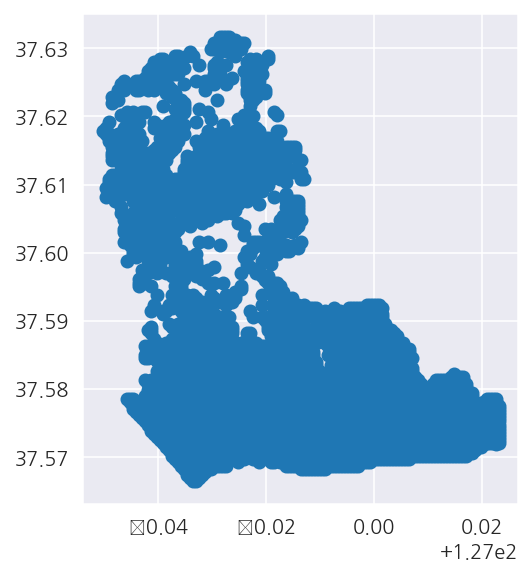

In [13]:
gdf_pop_4326.plot()

#### 좌표별 유동인구를 공간시각화

C:\Users\dhl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\dhl\anaconda3\lib\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\dhl\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


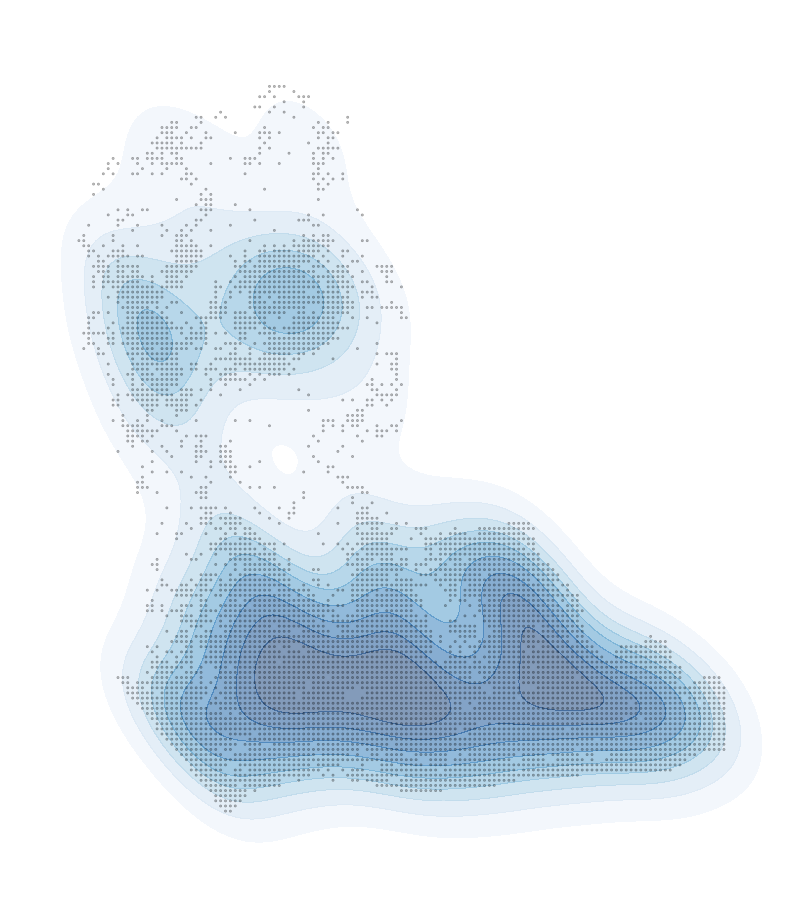

In [14]:
ax = gplt.kdeplot(gdf_pop_4326, cmap='Blues', shade=True, alpha=0.5, projection=gcrs.WebMercator(), figsize=(8, 8))
gplt.pointplot(gdf_pop_4326, s=0.4, color='black', alpha=0.4, ax=ax)

fig = plt.gcf()
plt.show()

C:\Users\dhl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dhl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


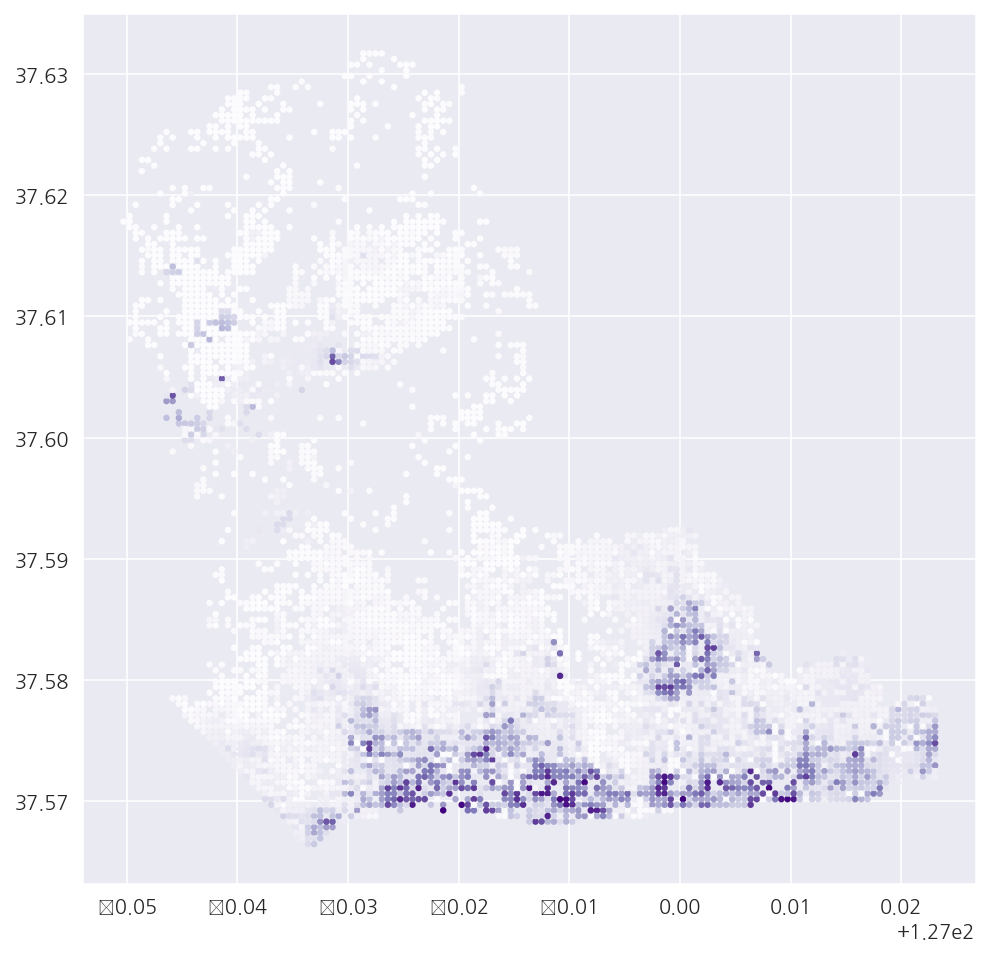

In [15]:
fig = plt.figure(figsize=(8,8))
plt.scatter(gdf_pop_4326.lon, gdf_pop_4326.lat, s=5, c=gdf_pop_4326.POP_ALL, cmap='Purples')

In [16]:
# SHP 저장
gdf_pop_4326.to_file('./data/pop/gdf_pop_4326.shp', encoding='utf-8')

# 패키지를 이용한 그리드 집계 및 시각화

### Pydeck 패키지 설치 및 설정 
Uber에서 만든 공간 시각화 패키지. deck.gl을 파이썬 환경으로 제작   
https://pypi.org/project/pydeck/  
https://pydeck.gl/index.html    
https://vis.gl/   

Anaconda Prompt를 **관리자 권한**으로 실행한 후,  아래 구문을 한 줄씩 복-붙하고 엔터   
3번째 줄 이후의 nbextension은 노트북 확장(extension) 기능으로 Pydeck 위젯 확장 기능을 적용하기 위함 

pip install pydeck  


conda install -c conda-forge jupyter_contrib_nbextensions  
jupyter contrib nbextension install --user  


jupyter nbextension install --sys-prefix --symlink --overwrite --py pydeck  
jupyter nbextension enable --sys-prefix --py pydeck  


### Mapbox 토큰 생성

Uber가 Mapbox와 제휴하여 개발해서인지 Mapbox API Key인 토큰(token) 정보가 필요함  
Mapbox 웹사이트(https://www.mapbox.com/)로 이동하고 화면 하단의 "Get Started for free" 버튼을 클릭하여 회원가입  
회원가입이 된 후에는 https://account.mapbox.com/access-tokens/ 로 접속하여 "Create a token"으로 토큰(API 키)을 생성하고 복사

In [17]:
import pydeck as pdk
from IPython.core.display import display
from IPython.display import display
import ipywidgets as widgets

In [18]:
# mapbox token 정보 읽기 
f = open('../../etc/mapbox.txt', 'r')
lines = f.readlines()
mapbox_token = lines[0]

In [19]:
MAPBOX_API_KEY = mapbox_token.replace("'","")  #문자열의 홑따옴표 제거
MAPBOX_API_KEY2 = mapbox_token.replace('"','')  #문자열의 쌍따옴표 제거

#### 일단 파이덱 샘플 코드를 실행해보자

In [20]:
# 2014 locations of car accidents in the UK
UK_ACCIDENTS_DATA = ('https://raw.githubusercontent.com/uber-common/'
                     'deck.gl-data/master/examples/3d-heatmap/heatmap-data.csv')

# Define a layer to display on a map
layer = pdk.Layer(
    'HexagonLayer',
    UK_ACCIDENTS_DATA,
    get_position=['lng', 'lat'],
    auto_highlight=True,
    elevation_scale=50,
    pickable=True,
    elevation_range=[0, 3000],
    extruded=True,                 
    coverage=1)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=-1.415,
    latitude=52.2323,
    zoom=6,
    min_zoom=5,
    max_zoom=15,
    pitch=40.5,
    bearing=-27.36)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, map_style='mapbox://styles/mapbox/dark-v9')
r.to_html('./result/demo.html')

#### HexagonLayer는 KDE plot(공간 히트맵)처럼 좌표의 밀도를 가지고 3차원 시각화해줌

In [21]:
# Define a layer to display on a map
layer = pdk.Layer(
    'ScatterplotLayer',
    gdf_pop_4326,
    get_position='[lon, lat]',
    get_radius=20,
    get_fill_color='[255 * pop_zscore, 0, 0]',  #빨강에 속성값을 곱해서 색상 구분
    opacity= 0.5,
    pickable=True,
    auto_highlight=True
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=126.98,
    latitude=37.59,
    zoom=12,
)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, map_style='mapbox://styles/mapbox/satellite-v9')  
#mapbox://styles/mapbox/streets-v10  
#light   dark  streets  outdoors  satellite

# html로 저장하고, 노트북에서는 안띄울 때
r.to_html('./result/pop_pydeck.html', notebook_display=True, iframe_width=900, iframe_height=500)
#r.show() # html 저장하지 않고 바로 보고싶은 경우 사용

In [22]:
# Define a layer to display on a map
layer = pdk.Layer(
    'ColumnLayer',
    gdf_pop_4326,
    get_position='[lon, lat]',
    extruded=True,                 
    get_elevation = '[POP_ALL]',  # 속성을 컬럼의 높이로
    elevation_scale= 0.5,  #3은 3배
    elevation_range=[0, 1000],
    radius= 25,  #헥사곤 기둥의 반경 길이
    coverage=0.9, #헥사곤 기중의 상대적 크기 1은 꽉 채운 상태
    get_fill_color='[255 * pop_zscore, 0, 255]',  #속성을 색상 구분에 적용
    opacity= 0.1,
    pickable=True,
    auto_highlight=True
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=126.96,
    latitude=37.60,
    zoom=12,
    min_zoom=5,
    max_zoom=15,
    pitch=25,
    bearing=-15)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, map_style='mapbox://styles/mapbox/streets-v10')  #mapbox://styles/mapbox/streets-v10
r.to_html('./result/pop_pydeck_columnLayer.html', notebook_display=True, iframe_width=900, iframe_height=500)
#r.show() # html 저장하지 않고 바로 보고싶은 경우 사용

In [23]:
# Define a layer to display on a map
layer = pdk.Layer(
    'HexagonLayer',  #  GridLayer,  , HeatmapLayer
    gdf_pop_4326,
    get_position='[lon, lat]',
    extruded=True,                 
    elevation_scale= 10,  #3은 3배
    elevation_range=[0, 100],
    radius= 100,  #헥사곤 기둥의 반경 길이
    coverage=1, #헥사곤 기중의 상대적 크기 1은 꽉 채운 상태
    opacity= 0.4
)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=126.96,
    latitude=37.60,
    zoom=12,
    min_zoom=5,
    max_zoom=15,
    pitch=25,
    bearing=-15)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, map_style='mapbox://styles/mapbox/dark-v9')  
#mapbox://styles/mapbox/streets-v10
r.to_html('./result/pop_pydeck_hexagonLayer.html', notebook_display=True, iframe_width=900, iframe_height=500)
#r.show() # html 저장하지 않고 바로 보고싶은 경우 사용

### 정리
- 공간적 밀도를 3D화 할 때에는 HexagonLayer, 이 때의 그리드 간격은 radius로 조정 (GridLayer, HeatmapLayer로도 가능)
- 속성값을 3D화 할 때에는 ColumnLayer, 높이는 get_elevation, 색상은 get_fill_color로 설정 


### 참조
- https://zzsza.github.io/data/2019/11/24/pydeck/  

- https://dailyheumsi.tistory.com/147    

- https://github.com/mincloud1501/Python   

## Plotly (with Mapbox) - Hexbin

In [24]:
# mapbox token 정보 읽기 
f = open('../../etc/mapbox.txt', 'r')
lines = f.readlines()
mapbox_token = lines[0]

In [25]:
MAPBOX_API_KEY2 = mapbox_token.replace('"','')  #문자열의 쌍따옴표 제거

In [47]:
import plotly.figure_factory as ff
import plotly.express as px

px.set_mapbox_access_token(MAPBOX_API_KEY2)
df = px.data.carshare()

fig = ff.create_hexbin_mapbox(
    data_frame=gdf_pop_4326, lat="lat", lon="lon",
    color="POP_ALL", #유동인구수를 색상 단계에 반영 
    nx_hexagon=20, #헥사곤 갯수 - 숫자가 커질수록 헥사콘 크기는 작아짐
    opacity=0.6, labels={"color": "Point Count"},
    min_count=10, #minimum count 파라미터
    show_original_data=True,  #원 포인트 표시
    original_data_marker=dict(size=2, opacity=0.4, color="black")    
)
#fig.update_layout(mapbox_style="dark", mapbox_accesstoken=MAPBOX_API_KEY2)

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "vWorld",
            "source": ["http://xdworld.vworld.kr:8080/2d/gray/service/{z}/{x}/{y}.png" ]
        }
      ])

fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

## 직접 격자를 만들어서 집계하고 시각화해보자

In [27]:
# 포인트 범위에 해당하는 격자 폴리곤 생성 
from shapely.geometry import Polygon

xmin,ymin,xmax,ymax =  gdf_pop_5179.total_bounds

length = 200  #세로 길이
wide = 200    #가로 길이

cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), wide))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )

grid200 = gpd.GeoDataFrame({'geometry':polygons})
#grid200.to_file("./data/grid.shp")

In [28]:
grid200.crs = "epsg:5179"

In [29]:
grid200['index'] = grid200.index  #폴리곤별 인덱스를 컬럼으로 생성 - 나중에 속성조인을 위해
grid200.info() 
grid200.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1221 non-null   geometry
 1   index     1221 non-null   int64   
dtypes: geometry(1), int64(1)
memory usage: 19.2 KB


geometry  index
0  POLYGON ((951437.000 1959230.000, 951637.000 1...      0
1  POLYGON ((951437.000 1959030.000, 951637.000 1...      1
2  POLYGON ((951437.000 1958830.000, 951637.000 1...      2
3  POLYGON ((951437.000 1958630.000, 951637.000 1...      3
4  POLYGON ((951437.000 1958430.000, 951637.000 1...      4

<AxesSubplot:>

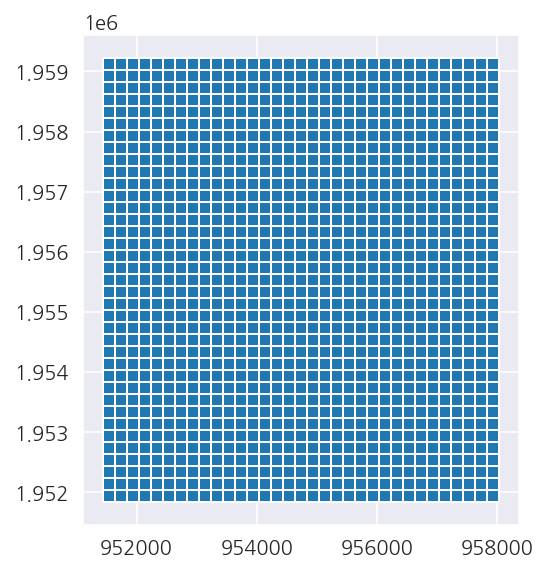

In [30]:
grid200.plot()

In [31]:
# 격자에 포인트 데이터를 공간조인 
grid_cnt = gpd.sjoin(grid200, gdf_pop_5179) #Spatial join Points to polygons
grid_cnt.info()
grid_cnt.head()

<ipython-input-31-21384a2bfb03>:2: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:5179
Right CRS: +init=epsg:5179 +type=crs




<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5621 entries, 4 to 1217
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     5621 non-null   geometry
 1   index        5621 non-null   int64   
 2   index_right  5621 non-null   int64   
 3   X_COORD      5621 non-null   float64 
 4   Y_COORD      5621 non-null   float64 
 5   POP_ALL      5621 non-null   float64 
 6   pop_zscore   5621 non-null   float64 
 7   outliers     5621 non-null   bool    
dtypes: bool(1), float64(4), geometry(1), int64(2)
memory usage: 356.8 KB


geometry  index  index_right  \
4  POLYGON ((951437.000 1958430.000, 951637.000 1...      4         2727   
4  POLYGON ((951437.000 1958430.000, 951637.000 1...      4         2725   
5  POLYGON ((951437.000 1958230.000, 951637.000 1...      5         2860   
6  POLYGON ((951437.000 1958030.000, 951637.000 1...      6         2858   
7  POLYGON ((951437.000 1957830.000, 951637.000 1...      7         2724   

       X_COORD    Y_COORD  POP_ALL  pop_zscore  outliers  
4  951636.6250  1958304.0     0.00   -0.540290     False  
4  951587.6250  1958305.0     6.51   -0.527913     False  
5  951587.1250  1958202.0    10.55   -0.520231     False  
6  951536.1875  1957894.0     9.11   -0.522969     False  
7  951583.8125  1957637.0     0.00   -0.540290     False

In [32]:
grid_cnt2 = grid_cnt.groupby(['index'])['POP_ALL'].agg('sum').reset_index() #격자별 유동인구 합계
#grid_cnt2['index'] = grid_cnt2.index_right 
grid_cnt2.info()
grid_cnt2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    617 non-null    int64  
 1   POP_ALL  617 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 9.8 KB


index  POP_ALL
0      4     6.51
1      5    10.55
2      6     9.11
3      7    28.78
4      8   114.79

In [33]:
# 원 격자 폴리곤에 집계값을 속성 조인 
grid_cnt3 = pd.merge(grid200, grid_cnt2, on='index', how='left')
grid_cnt3.info()
grid_cnt3.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1221 entries, 0 to 1220
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1221 non-null   geometry
 1   index     1221 non-null   int64   
 2   POP_ALL   617 non-null    float64 
dtypes: float64(1), geometry(1), int64(1)
memory usage: 38.2 KB


geometry  index  POP_ALL
0  POLYGON ((951437.000 1959230.000, 951637.000 1...      0      NaN
1  POLYGON ((951437.000 1959030.000, 951637.000 1...      1      NaN
2  POLYGON ((951437.000 1958830.000, 951637.000 1...      2      NaN
3  POLYGON ((951437.000 1958630.000, 951637.000 1...      3      NaN
4  POLYGON ((951437.000 1958430.000, 951637.000 1...      4     6.51

In [34]:
import contextily as ctx  #conda install contextily 또는 pip install contextily
import cartopy
import mapclassify as mc

In [35]:
grid_cnt3_4326 = grid_cnt3.to_crs(epsg=4326)   #4326으로 좌표계 변환
grid_cnt3_4326 = grid_cnt3_4326.dropna(axis=0) #null이 포함된 모든 행을 삭제

C:\Users\dhl\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning:


The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.



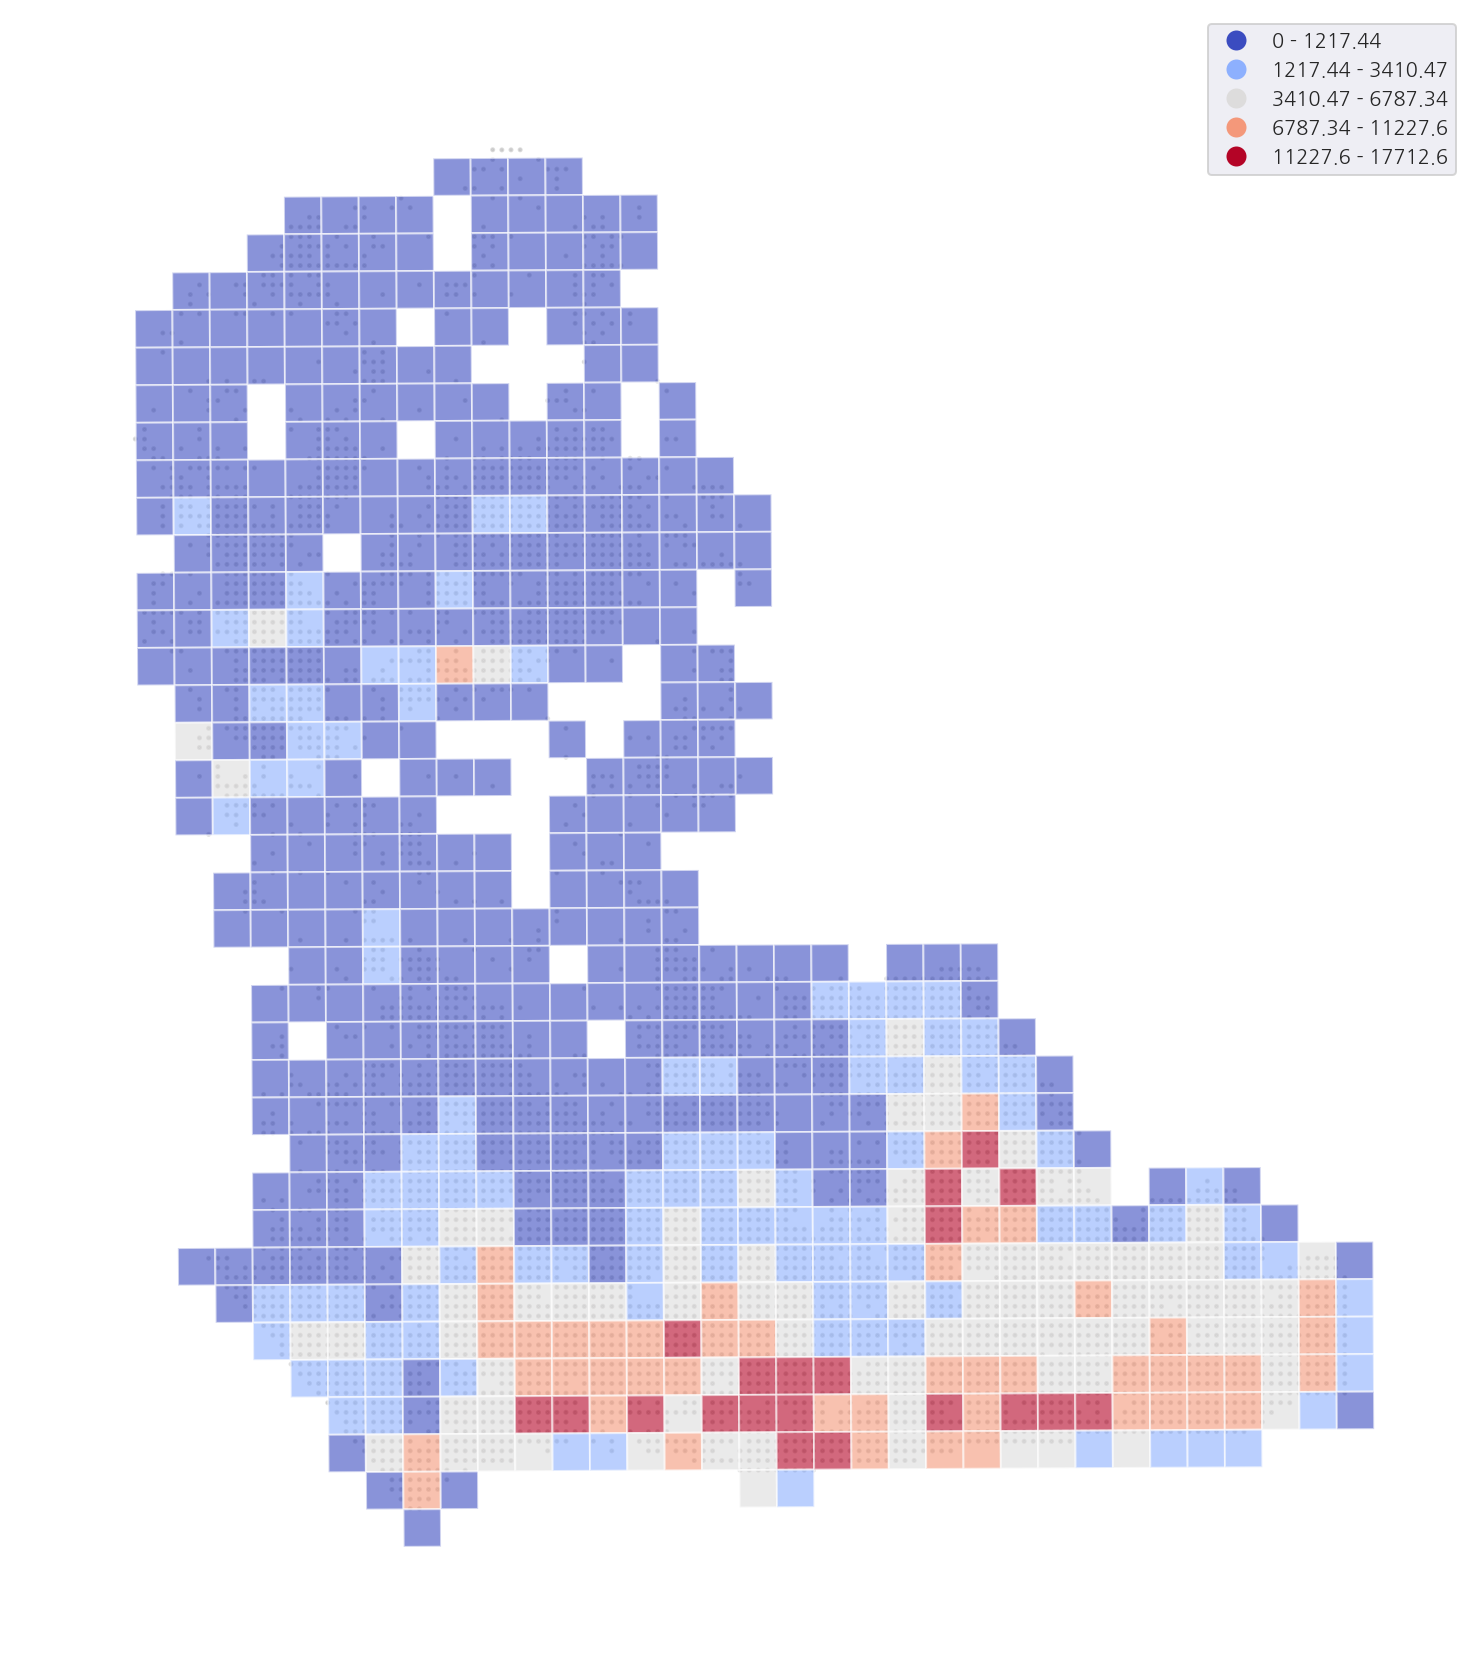

In [36]:
fig = plt.figure(figsize=(15,15))
proj = gcrs.WebMercator()
ax = plt.subplot(111, projection=proj)

# NaturalBreak 적용한 Choropleth(단계구분도)
#scheme = mc.Quantiles(grid_cnt3_4326['POP_ALL'], k=5)  #FisherJenksSampled, FisherJenks, NaturalBreaks, Quantiles
scheme = mc.NaturalBreaks(grid_cnt3_4326['POP_ALL'], k=5)  
ext = grid_cnt3_4326.total_bounds

#ax = gplt.webmap(grid_cnt3_4326, ax=ax)  #projection=gcrs.WebMercator(), provider='ST_TONER_LITE', figsize=(15, 15)
gplt.choropleth(grid_cnt3_4326, ax=ax, hue='POP_ALL', cmap='coolwarm', scheme=scheme, alpha=0.6, legend=True) 
#gplt.polyplot(grid_cnt3_4326, facecolor='none', edgecolor='white', linestyle='-', linewidth=1.5, alpha=1.0, zorder=-9999, ax=ax, extent=ext)  
gplt.pointplot(gdf_pop_4326, s=1.5, color='darkgray', alpha=0.4, ax=ax)

fig = plt.gcf()
#plt.savefig('./image/해정동별 환자수') #이미지 파일로 저장

In [37]:
grid_cnt3_3857 = grid_cnt3_4326.to_crs(epsg=3857)

C:\Users\dhl\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning:


The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.



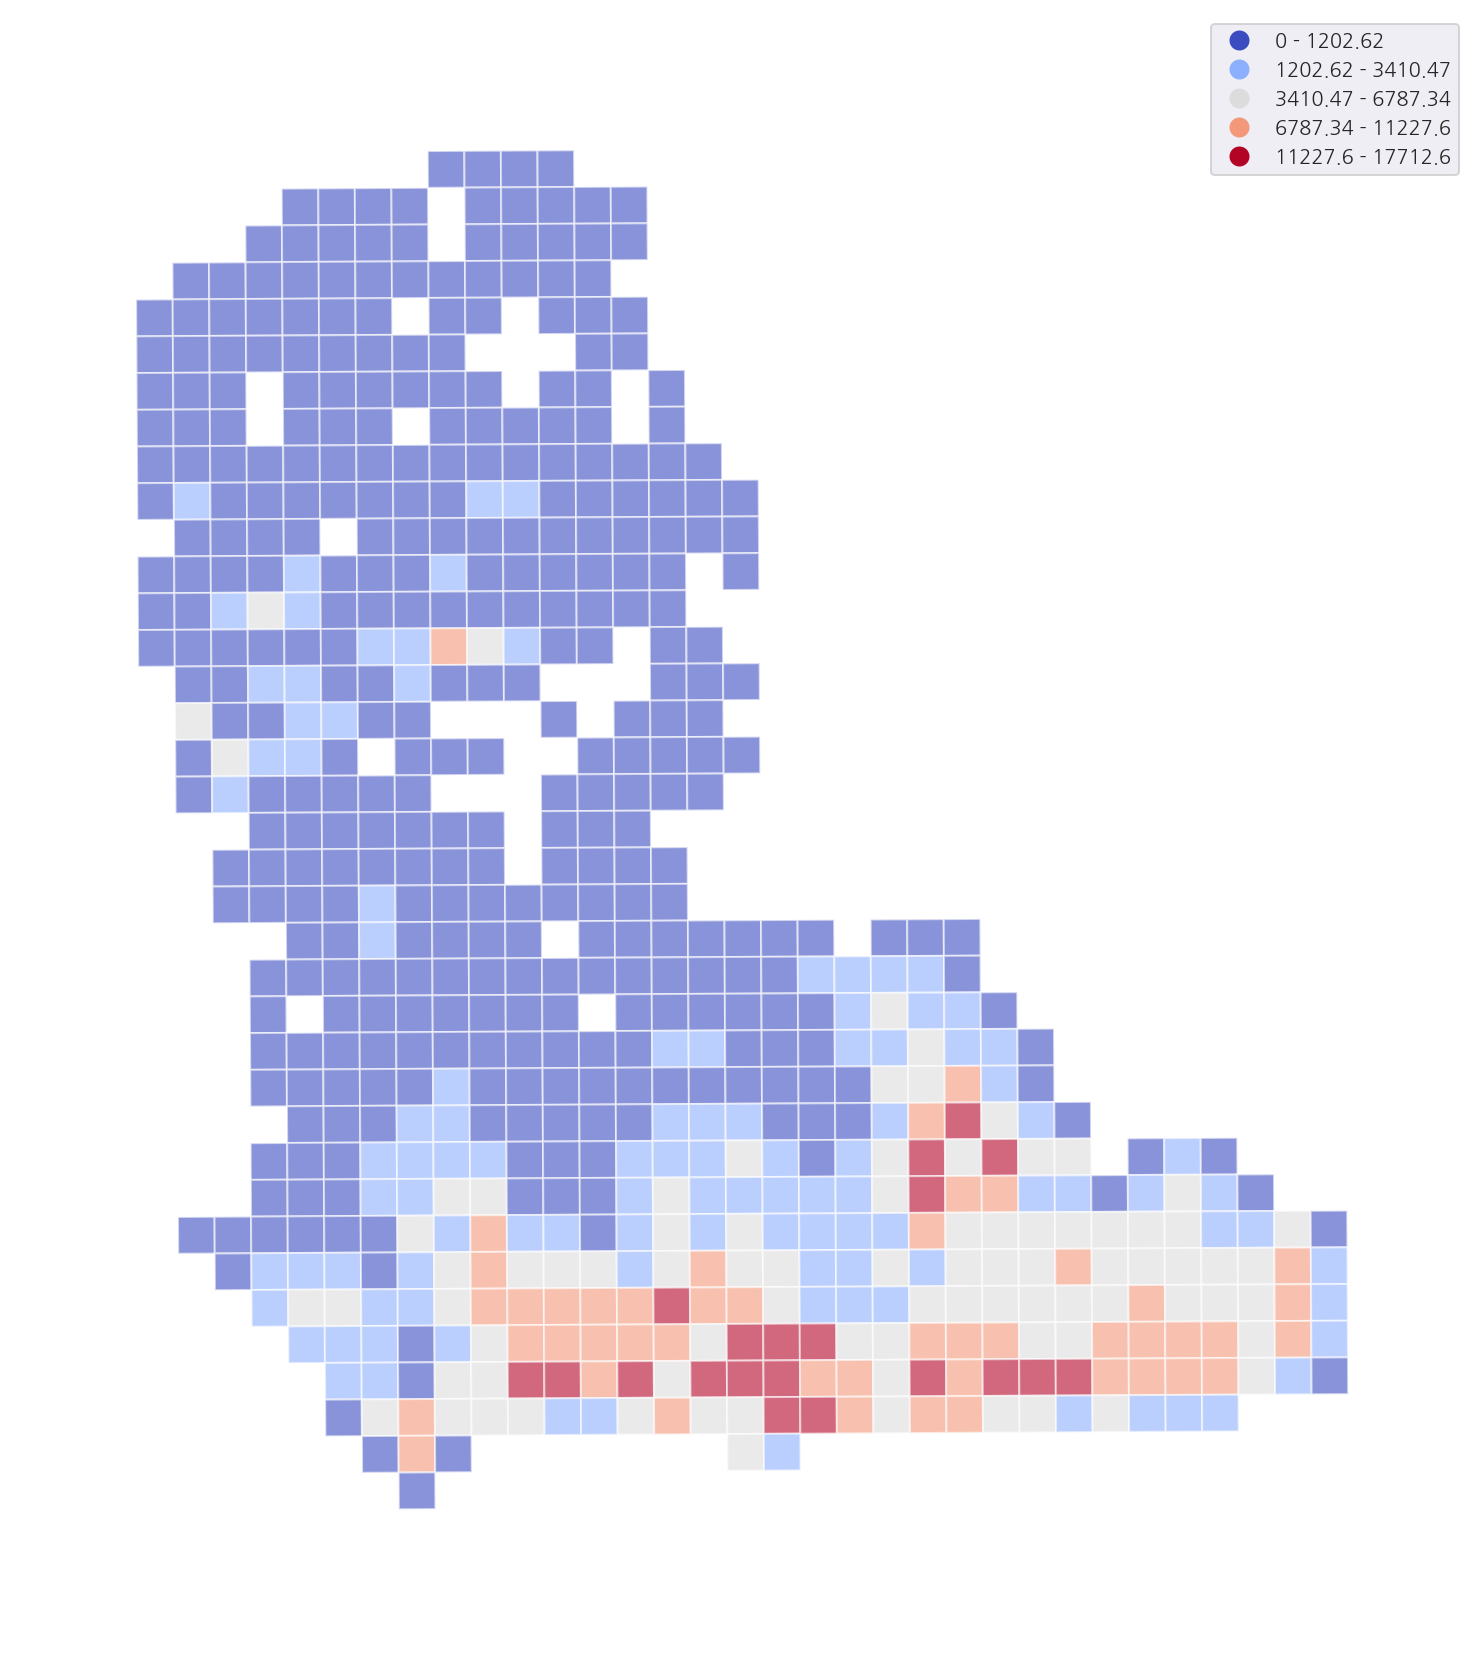

In [38]:
scheme = mc.NaturalBreaks(grid_cnt3_4326['POP_ALL'], k=5)  

fig = plt.figure(figsize=(15,15))
proj = gcrs.WebMercator()
ax = plt.subplot(111, projection=proj)

#ax = grid_cnt3_3857.plot(figsize=(15, 15), c=gdf_pop_4326.POP_ALL, cmap='Purples', alpha=0.6)
ax = gplt.choropleth(grid_cnt3_4326, ax=ax, hue='POP_ALL', cmap='coolwarm', scheme=scheme, alpha=0.6, legend=True) 

# choose any of the supported maps from ctx.sources
#ctx.add_basemap(ax) #, url=ctx.sources.ST_TERRAIN)

#url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
#layer_name = 'BlueMarble_ShadedRelief_Bathymetry'
#ax.add_wmts(url, layer_name, alpha = 0.9)
ax.set_axis_off()

plt.show()

# 수고 많으셨습니다!